In [8]:
import os
from collections import Counter

import nibabel as nib
import pandas as pd
import numpy as np
import scipy.stats as stats

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams['font.family'] = 'serif'

In [2]:
defa_ft = pd.read_csv('scores/scores_default_finetune.csv')
defa_st = pd.read_csv('scores/scores_default_scratch.csv')
segr_ft = pd.read_csv('scores/scores_segresnet_finetune.csv')
segr_st = pd.read_csv('scores/scores_segresnet_scratch.csv')
tver_ft = pd.read_csv('scores/scores_tverskybce_finetune.csv')
tver_st = pd.read_csv('scores/scores_tverskybce_scratch.csv')

regions = {
    'et': {
        'fullname': 'Enhancing Tumor',
        'subplot_id': '(a)'
    },
    'tc': {
        'fullname': 'Tumor Core',
        'subplot_id': '(b)'
    },
    'wt': {
        'fullname': 'Whole Tumor',
        'subplot_id': '(c)'
    }
}
regions_labels = {'et': '(a)', 'tc': '(b)', 'wt': '(c)'}

metrics = [
    'DICE_et', 'DICE_tc', 'DICE_wt',
    'Hausdorff_et', 'Hausdorff_tc', 'Hausdorff_wt',
    'Sensitivity_et', 'Sensitivity_tc', 'Sensitivity_wt',
    'Specificity_et', 'Specificity_tc', 'Specificity_wt'
]
models = ["Default", "SegResNet", "TverskyBCE"]

color_fine_tune = 'tab:blue'
color_scratch = 'tab:cyan'
dataframes = {
    'Default Fine-tuned'        : defa_ft,
    'Default Scratch-trained'   : defa_st,
    'SegResNet Fine-tuned'      : segr_ft,
    'SegResNet Scratch-trained' : segr_st,
    'TverskyBCE Fine-tuned'     : tver_ft,
    'TverskyBCE Scratch-trained': tver_st,
}

def savefig(fig, filename):
    fig.savefig(f'data/img/{filename}.jpg', format='jpeg', dpi=600)

## 1. Quantitative Analysis

### 1.1. Dice score

In [3]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    stderr = stats.sem(data)
    margin = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, stderr, (mean - margin, mean + margin)

# Analyze Dice scores in terms of mean, std, and confidence interval for Fine-tunedddd vs scratch-trained models
analysis_data = []

for model in models:
    for metric in metrics:
        fine_tune_scores = dataframes[f"{model} Fine-tuned"][metric]
        scratch_scores = dataframes[f"{model} Scratch-trained"][metric]
        
        # Fine-tuned analysis
        fine_mean, fine_std, fine_ci = confidence_interval(fine_tune_scores)
        
        # Scratch analysis
        scratch_mean, scratch_std, scratch_ci = confidence_interval(scratch_scores)
        
        # Append data for comparison
        analysis_data.append({
            "Model": model,
            "Metric": metric,
            "Fine-tuned Mean": fine_mean,
            "Fine-tuned Std": np.std(fine_tune_scores),
            "Fine-tuned 95% CI": fine_ci,
            "Scratch-trained Mean": scratch_mean,
            "Scratch-trained Std": np.std(scratch_scores),
            "Scratch-trained 95% CI": scratch_ci
        })
        

analysis_df = pd.DataFrame(analysis_data)
analysis_df


,Model,Metric,Fine-tuned Mean,Fine-tuned Std,Fine-tuned 95% CI,Scratch-trained Mean,Scratch-trained Std,Scratch-trained 95% CI
0,Default,DICE_et,0.905191,0.060529,"(0.859549341624805, 0.9508327463394337)",0.901867,0.057865,"(0.8582334897754873, 0.9455003348997137)"
1,Default,DICE_tc,0.936469,0.071900,"(0.8822524963577102, 0.9906857526174232)",0.933502,0.055110,"(0.8919465610464932, 0.9750583825586496)"
2,Default,DICE_wt,0.914037,0.041628,"(0.882647150589266, 0.9454264331970087)",0.906628,0.049443,"(0.8693458854715259, 0.9439104008057466)"
3,Default,Hausdorff_et,2.762155,2.417748,"(0.93904634688434, 4.585264241701764)",2.779166,1.910823,"(1.3383056832415954, 4.220027188363806)"
4,Default,Hausdorff_tc,1.866159,1.625563,"(0.6403992643478642, 3.091917897747358)",5.496081,7.988633,"(-0.5277663175307872, 11.519929030435236)"
5,Default,Hausdorff_wt,3.360934,2.231400,"(1.6783408756145728, 5.0435261535722855)",3.229426,2.306694,"(1.4900580865946316, 4.968793743827349)"
6,Default,Sensitivity_et,0.891776,0.094680,"(0.8203824550989757, 0.9631701475002804)",0.883308,0.091064,"(0.8146406773785713, 0.9519750045707722)"
7,Default,Sensitivity_tc,0.903716,0.116150,"(0.8161332147806754, 0.9912988415566176)",0.898394,0.095828,"(0.8261347655108316, 0.970654110237675)"
8,Default,Sensitivity_wt,0.859142,0.074822,"(0.8027226144034422, 0.9155623250541202)",0.850488,0.094375,"(0.7793244269034129, 0.9216522552930121)"
9,Default,Specificity_et,0.999855,0.000174,"(0.999724490193551, 0.9999863139471169)",0.999864,0.000153,"(0.9997483523105747, 0.9999796072276904)"


In [4]:
# analysis_df.to_csv('score_summary.csv', index=False)

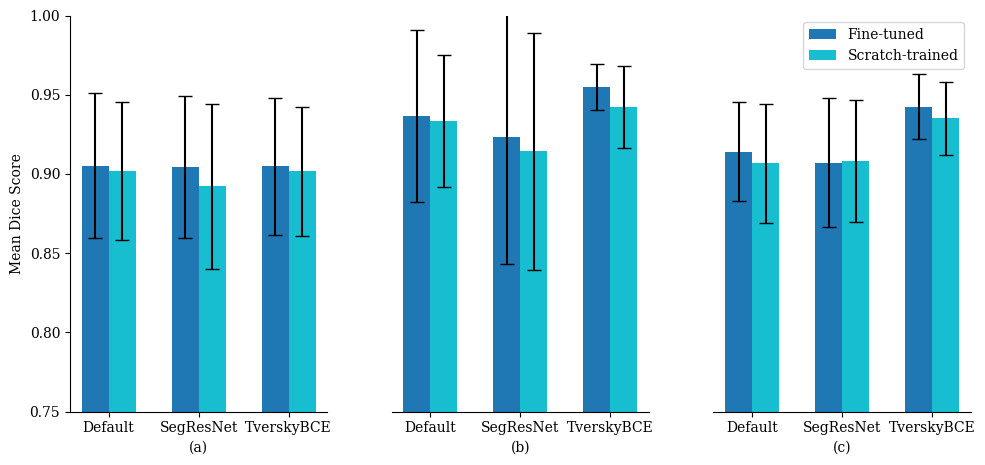

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10,5), sharey=True)
dice_metrics = ['DICE_et', 'DICE_tc', 'DICE_wt',]

for i, metric in enumerate(dice_metrics):
    ax = axes[i]
    fine_means = [analysis_df[(analysis_df['Model'] == model) & (analysis_df['Metric'] == metric)]['Fine-tuned Mean'].values[0] for model in models]
    scratch_means = [analysis_df[(analysis_df['Model'] == model) & (analysis_df['Metric'] == metric)]['Scratch-trained Mean'].values[0] for model in models]
    fine_cis = [analysis_df[(analysis_df['Model'] == model) & (analysis_df['Metric'] == metric)]['Fine-tuned 95% CI'].values[0] for model in models]
    scratch_cis = [analysis_df[(analysis_df['Model'] == model) & (analysis_df['Metric'] == metric)]['Scratch-trained 95% CI'].values[0] for model in models]
    
    # Error bars for confidence intervals
    fine_errors = [((ci[1] - mean), (mean - ci[0])) for mean, ci in zip(fine_means, fine_cis)]
    scratch_errors = [((ci[1] - mean), (mean - ci[0])) for mean, ci in zip(scratch_means, scratch_cis)]
    
    # Extracting positive and negative errors
    fine_errors = np.array(fine_errors).T
    scratch_errors = np.array(scratch_errors).T
    
    x = np.arange(len(models))  # the label locations
    width = 0.3  # width of the bars

    # Plotting Fine-tunedd and scratch-trained bars
    ax.bar(x - width/2, fine_means, width, yerr=fine_errors, label='Fine-tuned', capsize=5, color=color_fine_tune)
    ax.bar(x + width/2, scratch_means, width, yerr=scratch_errors, label='Scratch-trained', capsize=5, color=color_scratch, linestyle='--')
    
    #ax.set_title(regions[metric[-2:]], pad=20)
    ax.set_xlabel(regions[metric[-2:]]['subplot_id'])
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0.75, 1.0)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i > 0: # apply for 2nd and 3rd ax only
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='major', color='w')


axes[0].set_ylabel('Mean Dice Score')
axes[-1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.25)
plt.show()
savefig(fig, 'dice_ftst')

### 1.2. Hausdorff Distance

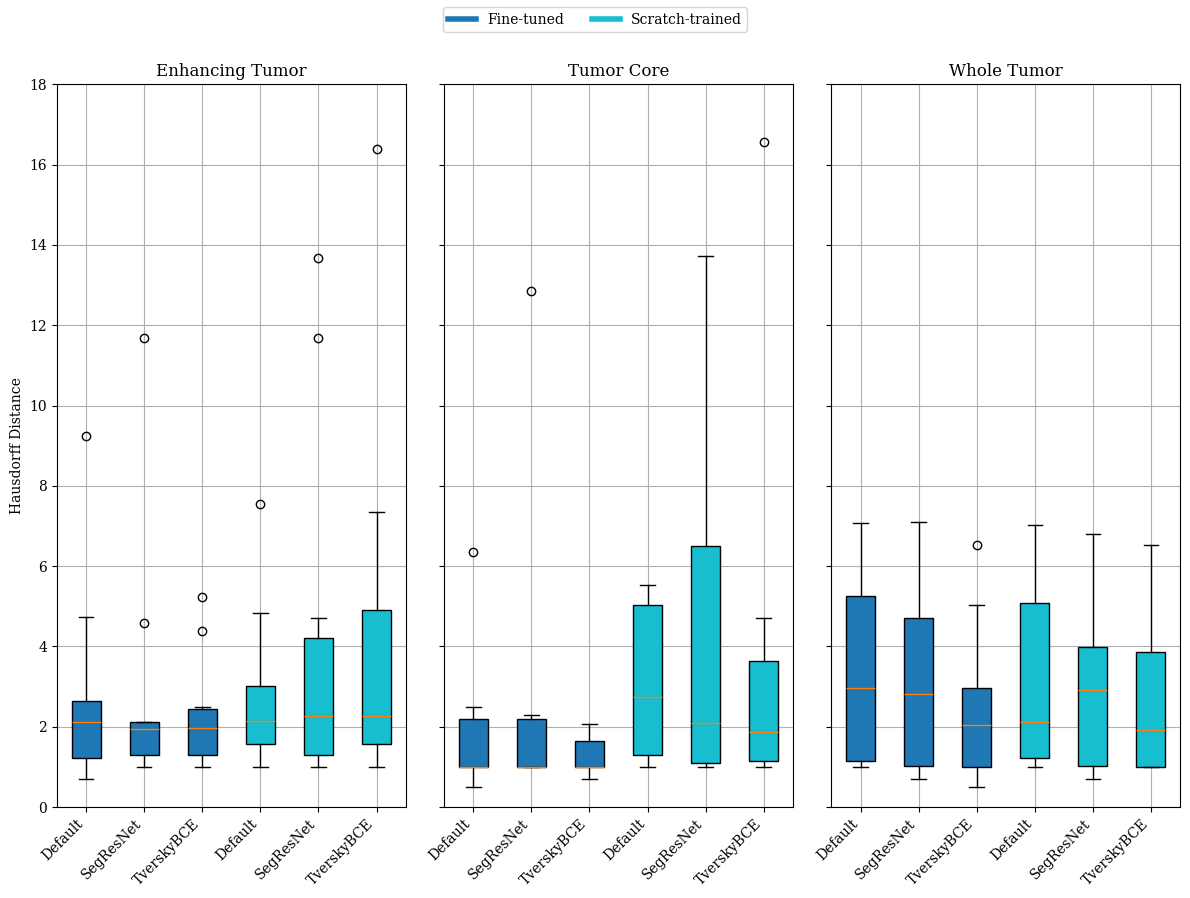

In [6]:
# Fixing the legend to display different colors for Fine-tunedd and scratch-trained models

hausdorff_metrics = ['Hausdorff_et', 'Hausdorff_tc', 'Hausdorff_wt']

fig, axes = plt.subplots(1, 3, figsize=(12, 9), sharey=True)
color_fine_tune = 'tab:blue'
color_scratch = 'tab:cyan'

for i, metric in enumerate(hausdorff_metrics):
    ax = axes[i]
    
    # Data for boxplot
    fine_tune_data = [dataframes[f"{model} Fine-tuned"][metric] for model in models]
    scratch_data = [dataframes[f"{model} Scratch-trained"][metric] for model in models]

    # Concatenating Fine-tuned and scratch data for boxplot
    box_data = fine_tune_data + scratch_data
    labels = models * 2
    colors = [color_fine_tune] * len(fine_tune_data) + [color_scratch] * len(scratch_data)

    # Plotting boxplots with distinct colors for Fine-tuned and scratch
    box = ax.boxplot(box_data, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(regions[metric[-2:]]['fullname'])
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(models * 2, rotation=45, ha='right')
    ax.grid(True)
    ax.set_ylim(0, 18)

axes[0].set_ylabel('Hausdorff Distance')

# Creating a custom legend to show different colors for Fine-tunedd and scratch-trained
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color_fine_tune, lw=4, label='Fine-tuned'),
    Line2D([0], [0], color=color_scratch, lw=4, label='Scratch-trained')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


savefig(fig, 'hd_ftst')


## 2. Individual Case Analysis

In [3]:
idcol = 'sample'
ids = defa_ft[idcol]

# Columns that values higher are better
hbcols = [
    'DICE_et',
    'DICE_tc',
    'DICE_wt',
    'Sensitivity_et',
    'Sensitivity_tc',
    'Sensitivity_wt',
    'Specificity_et',
    'Specificity_tc',
    'Specificity_wt',
]

# Columns that values lower are better
lbcols = ['Hausdorff_et', 'Hausdorff_tc', 'Hausdorff_wt']

# Columns to compare volume of tumors
volcols = [
    'True_volume_et',
    'True_volume_tc',
    'True_volume_wt',
    'Predicted_volume_et',
    'Predicted_volume_tc',
    'Predicted_volume_wt'
]

In [ ]:
challenging_cases_indices = []

for model in dataframes.values():
    for col in hbcols:
        # Get ids of cases that values are lowest where they should be high
        challenging_case_idx = model[col].idxmin(axis=0)
        challenging_cases_indices.append(challenging_case_idx)

    for col in lbcols:
        # Get ids of cases that values are highest where they should be low
        challenging_case_idx = model[col].idxmax(axis=0)
        challenging_cases_indices.append(challenging_case_idx)

# Count numbers of apprearance of these indices marked as challenging cases
challenging_cases_fns = [ids[challenging_case_idx] for challenging_case_idx in challenging_cases_indices]
counter = Counter(challenging_cases_indices)
counter_fns = Counter(challenging_cases_fns)
counter, counter_fns

(Counter({7: 24, 5: 11, 9: 8, 1: 7, 3: 7, 8: 5, 0: 4, 4: 3, 2: 2, 6: 1}),
 Counter({'SBT-MET-B000733-20181114.nii.gz': 24,
          'SBT-MET-B000731-20180316.nii.gz': 11,
          'SBT-MET-D000739-20180319.nii.gz': 8,
          'SBT-MET-A000726-20180528.nii.gz': 7,
          'SBT-MET-A000728-20180326.nii.gz': 7,
          'SBT-MET-B000734-20180423.nii.gz': 5,
          'SBT-MET-B000730-20180517.nii.gz': 4,
          'SBT-MET-A000729-20181109.nii.gz': 3,
          'SBT-MET-A000727-20180724.nii.gz': 2,
          'SBT-MET-B000732-20161017.nii.gz': 1}))

In [6]:
# We select case index 7, 5, and 9 because they have more challenge occurance
selected_case_ids = [7, 5, 9]
selected_case_fns = [defa_ft.loc[id_, 'sample'] for id_ in selected_case_ids]
selected_case_fns

['SBT-MET-B000733-20181114.nii.gz',
 'SBT-MET-B000731-20180316.nii.gz',
 'SBT-MET-D000739-20180319.nii.gz']

In [7]:
def get_dice_dict(score_df, metric):
    scores = score_df.copy()
    scores = scores.set_index('sample')
    return scores.loc[selected_case_fns, metric].to_dict()

metric_columns = (
    'DICE_et', 'DICE_tc', 'DICE_wt',
    'Hausdorff_et', 'Hausdorff_tc', 'Hausdorff_wt',
    'Sensitivity_et', 'Sensitivity_tc', 'Sensitivity_wt',
    'Specificity_et', 'Specificity_tc', 'Specificity_wt',
)

# A dictionary that stores all metric scores of 4 selected cases of each model 
metric_dict = {
    'defa_ft': {
        metric: get_dice_dict(defa_ft, metric) for metric in metric_columns
    },
    'defa_st': {
        metric: get_dice_dict(defa_st, metric) for metric in metric_columns
    },
    'segr_ft': {
        metric: get_dice_dict(segr_ft, metric) for metric in metric_columns
    },
    'segr_st': {
        metric: get_dice_dict(segr_st, metric) for metric in metric_columns
    },
    'tver_ft': {
        metric: get_dice_dict(tver_ft, metric) for metric in metric_columns
    },
    'tver_st':{
        metric: get_dice_dict(tver_st, metric) for metric in metric_columns
    }
}

selected_image_fps = [
    os.path.join('/media/storage/luu/nnUNet_raw/Dataset222_SBT/imagesTs', fn.replace('.nii.gz', '_0000.nii.gz')) \
            for fn in selected_case_fns
]
selected_label_paths = [
    os.path.join('/media/storage/luu/nnUNet_raw/Dataset222_SBT/labelsTs', fn) \
            for fn in selected_case_fns
]

pred_paths = {
    'defa_ft': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/default_finetune_preds', fn) \
            for fn in selected_case_fns
    ],
    'defa_st': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/default_scratch_preds', fn) \
            for fn in selected_case_fns
    ],
    'segr_ft': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/segresnet_finetune_preds', fn) \
            for fn in selected_case_fns
    ],
    'segr_st': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/segresnet_scratch_preds', fn) \
            for fn in selected_case_fns
    ],
    'tver_ft': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/tverskybce_finetune_preds', fn) \
            for fn in selected_case_fns
    ],
    'tver_st': [
        os.path.join('/media/storage/luu/nnUNet_predictions/Dataset222_SBT/tverskybce_scratch_preds', fn) \
            for fn in selected_case_fns
    ],
}

region_mapping = {
    'WT': 'Whole Tumor',
    'TC': 'Tumor Core',
    'ET': 'Enhancing Tumor'
}
model_mapping = {
    'defa_ft': 'Default Fine-tuned',
    'defa_st': 'Default Scratch-trained',
    'segr_ft': 'SegResNet Fine-tuned',
    'segr_st': 'SegResNet Scratch-trained',
    'tver_ft': 'TverskyBCE Fine-tuned',
    'tver_st': 'TverskyBCE Scratch-trained'
}

In [8]:
selected_image_fps

['/media/storage/luu/nnUNet_raw/Dataset222_SBT/imagesTs/SBT-MET-B000733-20181114_0000.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset222_SBT/imagesTs/SBT-MET-B000731-20180316_0000.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset222_SBT/imagesTs/SBT-MET-D000739-20180319_0000.nii.gz']

In [9]:
def convert_to_regions(labels):
    """Converts segmentation labels to specific regions."""
    labels = np.round(labels).astype(np.uint8)

    return {
        "WT": np.isin(labels, [1, 2, 3]).astype(np.uint8),
        "TC": np.isin(labels, [1, 3]).astype(np.uint8),
        "ET": (labels == 3).astype(np.uint8)
    }

def plot_image(ax, image, title, slice_idx):
    """Plots a single image on the given axis with the provided title."""
    ax.imshow(image[..., slice_idx], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def plot_segmentation_results(axs, predictions,
                              model_names, slice_idx,
                              case_id, region, row_idx):
    """Plots the predictions and metrics for each model."""
    for i, prediction in enumerate(predictions):
        model_shortname = model_names[i]
        model_fullname  = model_mapping[model_shortname]

        case_filename = f'{case_id}.nii.gz'
        metrics = {
            "dsc": metric_dict[model_shortname][f'DICE_{region.lower()}'][case_filename],
            "hd": metric_dict[model_shortname][f'Hausdorff_{region.lower()}'][case_filename],
            "sen": metric_dict[model_shortname][f'Sensitivity_{region.lower()}'][case_filename],
            "spe": metric_dict[model_shortname][f'Specificity_{region.lower()}'][case_filename]
        }

        ax = axs[row_idx, i]
        plot_image(
            ax, prediction,
            f'{model_fullname}\nDSC={metrics["dsc"]:.2f}, HD={metrics["hd"]:.2f}\nSEN={metrics["sen"]:.2f}, SPE={metrics["spe"]:.2f}',
            slice_idx
        )

def visualize_segmentation_results(image, ground_truth,
                                   predictions, model_names,
                                   slice_idx, case_id,
                                   region, is_3d=False, save_path=None):
    """Visualizes segmentation results in 2D or 3D."""
    fig, axs = plt.subplots(2, 6, figsize=(15, 6))
    
    # Disable unused axes in the first row
    for i in range(2, 6):
        axs[0, i].axis('off')

    # Show 3 digits of the id (for manuscript)
    # For example, id 'SBT-MET-B000733-20181114' becomes '733'
    case_id_to_show = case_id.split('-')[2][-3:]
    
    if is_3d:
        camera = Camera(fig)
        for slice_idx in range(image.shape[2]):
            # For manuscript
            plot_image(axs[0, 0], image, f'Image {case_id_to_show} - {slice_idx}', slice_idx)
            #plot_image(axs[0, 0], image, f'{case_id} - {slice_idx}', slice_idx)
            plot_image(axs[0, 1], ground_truth, f'Ground truth of\n{region_mapping[region]}', slice_idx)
            plot_segmentation_results(axs, predictions, model_names, slice_idx, case_id, region, row_idx=1)
            camera.snap()
        plt.close()
        return camera.animate()
    else:
        # For manuscript
        plot_image(axs[0, 0], image, f'Image {case_id_to_show}', slice_idx)
        #plot_image(axs[0, 0], image, f'{case_id_to_show} - {slice_idx}', slice_idx)
        plot_image(axs[0, 1], ground_truth, f'Ground truth of\n{region_mapping[region]}', slice_idx)
        plot_segmentation_results(axs, predictions, model_names, slice_idx, case_id, region, row_idx=1)
        fig.tight_layout()
        
        if save_path:
            fig.savefig(save_path, format='jpeg', dpi=600)
        plt.show()

def visualize_case(case_idx, region, slice_idx=100, is_3d=False, save_path=None):
    """Loads data and visualizes segmentation for a given case."""
    case_id = selected_case_fns[case_idx].replace('.nii.gz', '')
    image = nib.load(selected_image_fps[case_idx]).get_fdata()
    ground_truth = convert_to_regions(nib.load(selected_label_paths[case_idx]).get_fdata())[region]

    predictions = [
        convert_to_regions(nib.load(model_pred_paths[case_idx]).get_fdata())[region] \
            for model_pred_paths in pred_paths.values()
    ]
    model_names = list(pred_paths.keys())
    
    return visualize_segmentation_results(
        image=image,
        ground_truth=ground_truth,
        predictions=predictions,
        model_names=model_names,
        slice_idx=slice_idx,
        case_id=case_id,
        region=region,
        is_3d=is_3d,
        save_path=save_path,
    )

def visualize2d(case_idx, region='ET', slice_idx=100, save_path=None):
    """Visualizes segmentation results in 2D."""
    visualize_case(
        case_idx=case_idx,
        region=region,
        slice_idx=slice_idx,
        is_3d=False,
        save_path=save_path
    )

def visualize3d(case_idx, region):
    """Visualizes segmentation results in 3D."""
    return visualize_case(
        case_idx,
        region,
        is_3d=True
    )


#### Case 0 (SBT-MET-B000733-20181114):

- Tversky Fine-tuned better at not missing tumor regions (False Negative)

In [55]:
animation = visualize3d(
    case_idx=0,
    region='WT'
)

HTML(animation.to_html5_video()) 

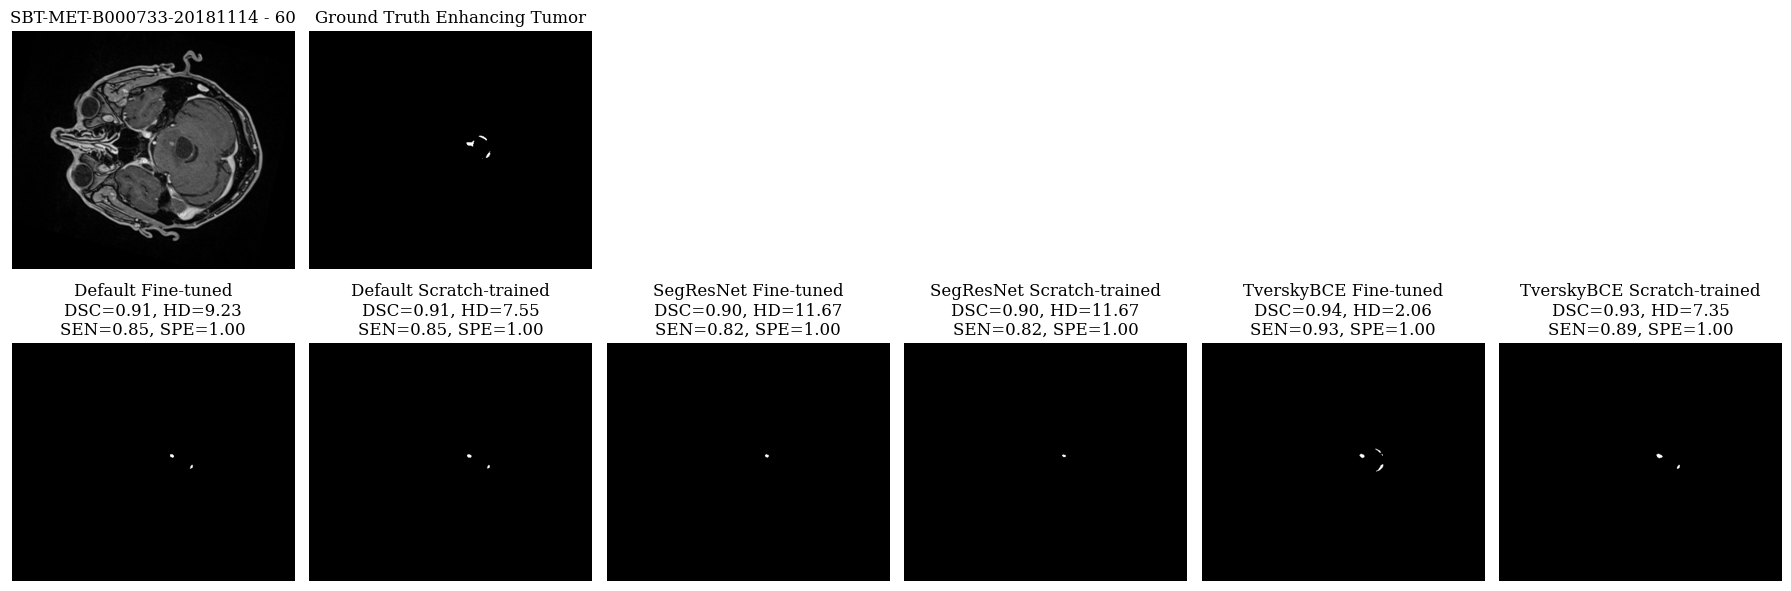

In [41]:
visualize2d(
    case_idx=0,
    slice_idx=60,
    region='ET'
)  

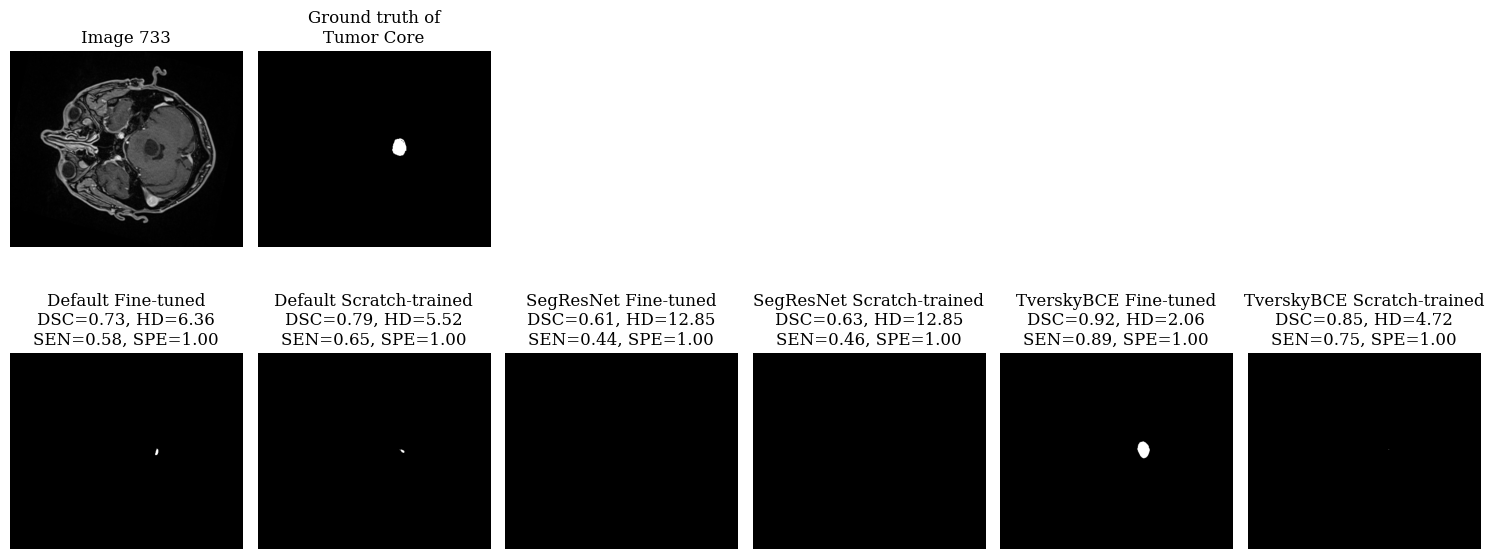

In [54]:
visualize2d(
    case_idx=0,
    slice_idx=58,
    region='TC',
    save_path='img/733.jpg'
)  

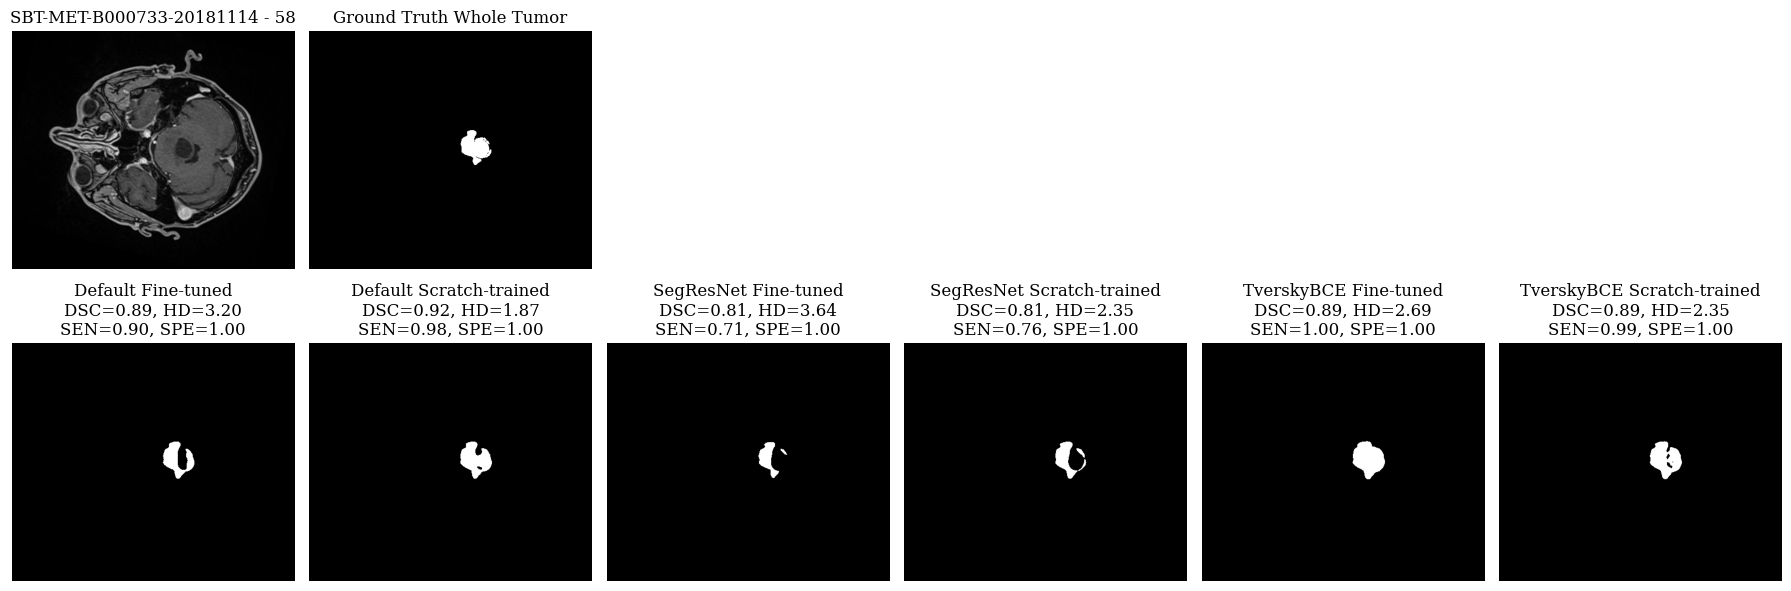

In [18]:
visualize2d(
    case_idx=0,
    slice_idx=58,
    region='WT'
)  

#### Case 1 (SBT-MET-B000731-20180316)

- Tumor is small
- TverskyBCE Fine-tuned better at not missing tumor (False Negative), more overlapping, high SEN
- TverskyBCE Scratch-trained has higer DSC, but it visually missing more tumor than Fine-tuned.

In [56]:
animation = visualize3d(
    case_idx=1,
    region='WT'
)

HTML(animation.to_html5_video()) 

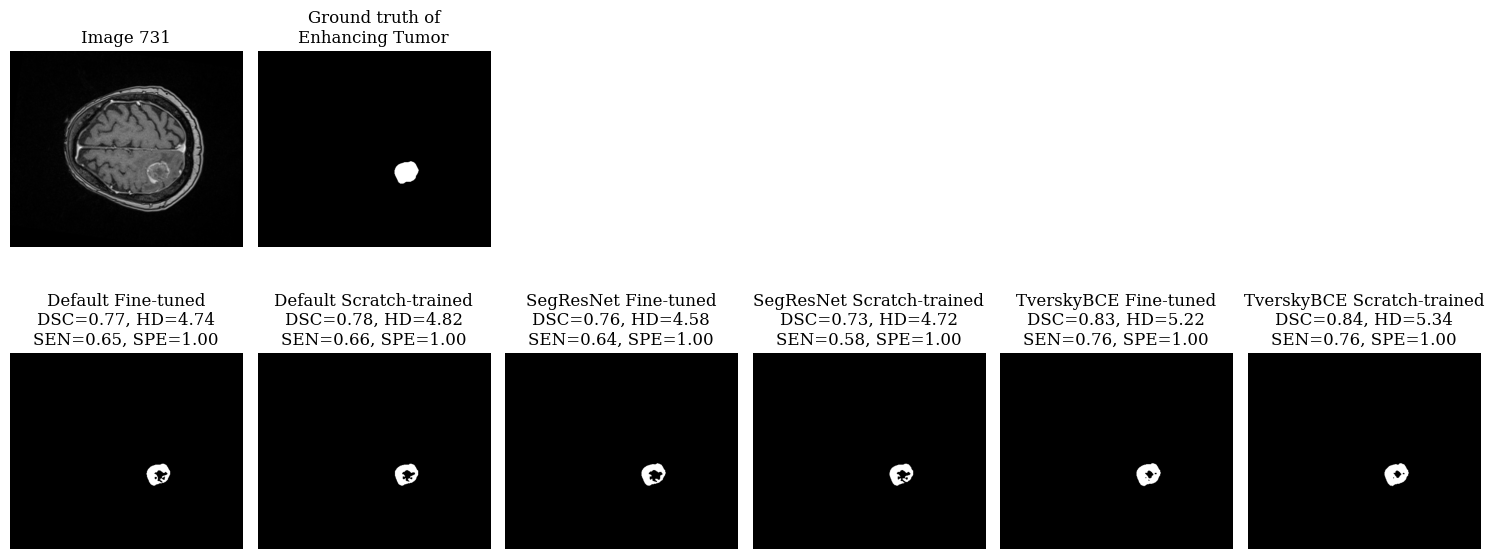

In [58]:
visualize2d(
    case_idx=1,
    slice_idx=135,
    region='ET',
    save_path='img/731.jpg'
) 

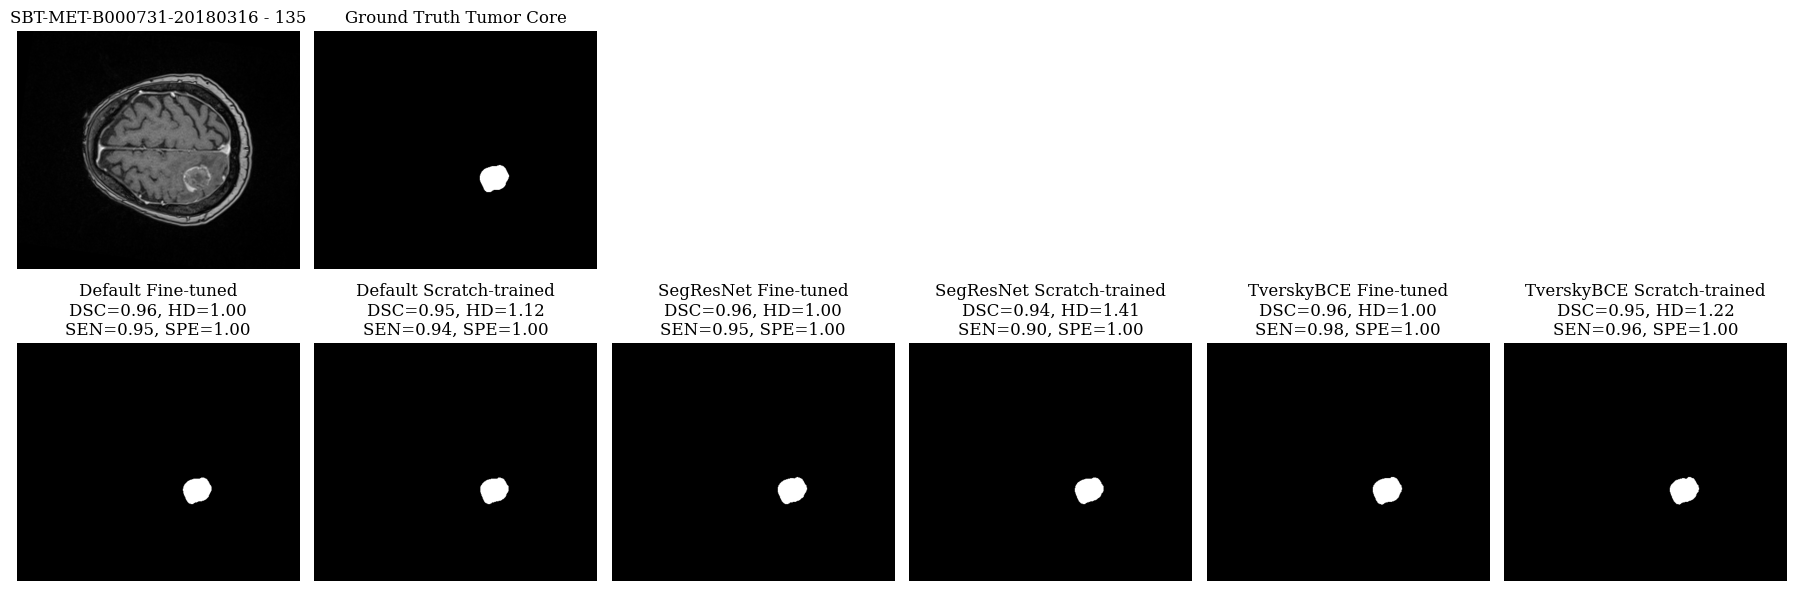

In [24]:
visualize2d(
    case_idx=1,
    slice_idx=135,
    region='TC'
) 

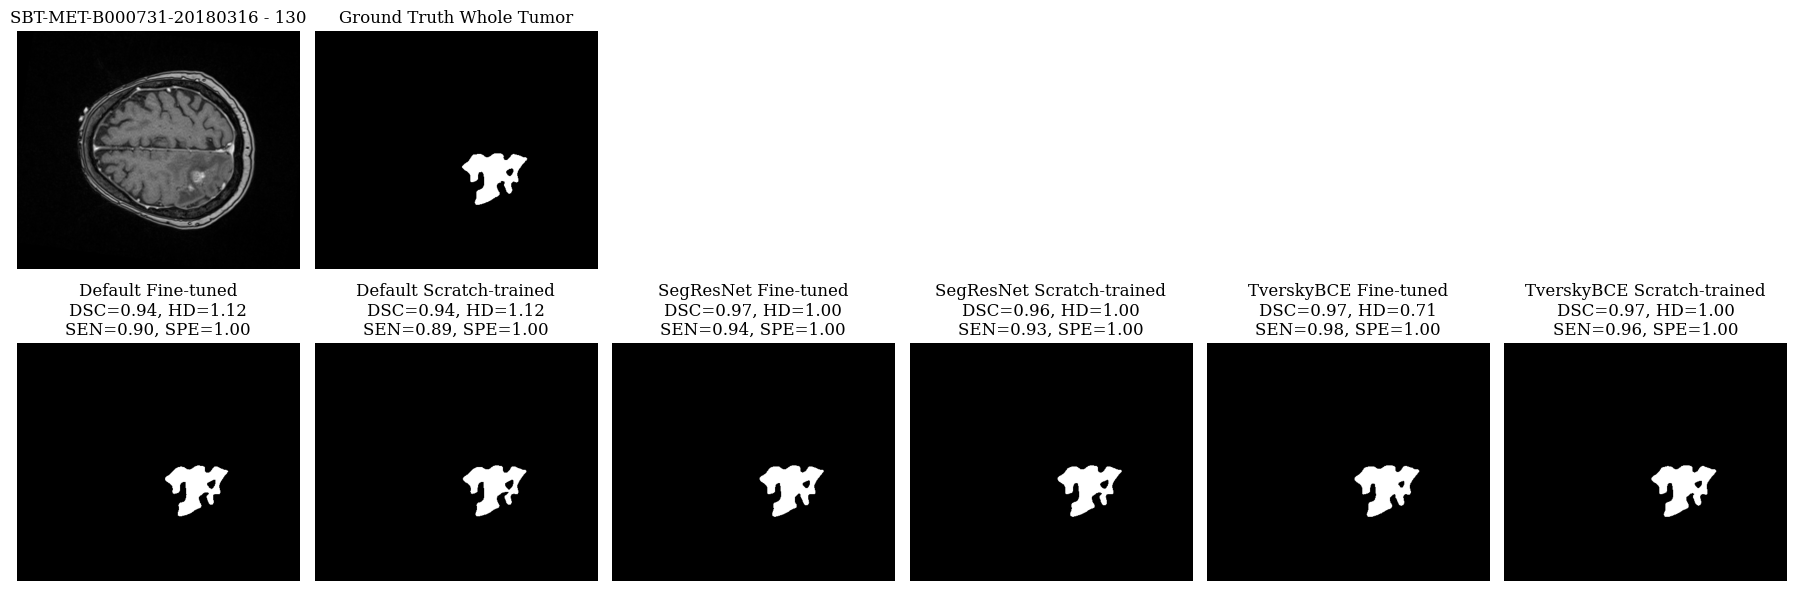

In [27]:
visualize2d(
    case_idx=1,
    slice_idx=130,
    region='WT'
) 

#### Case 2 (SBT-MET-D000739-20180319):



In [28]:
animation = visualize3d(
    case_idx=2,
    region='WT'
)

HTML(animation.to_html5_video())

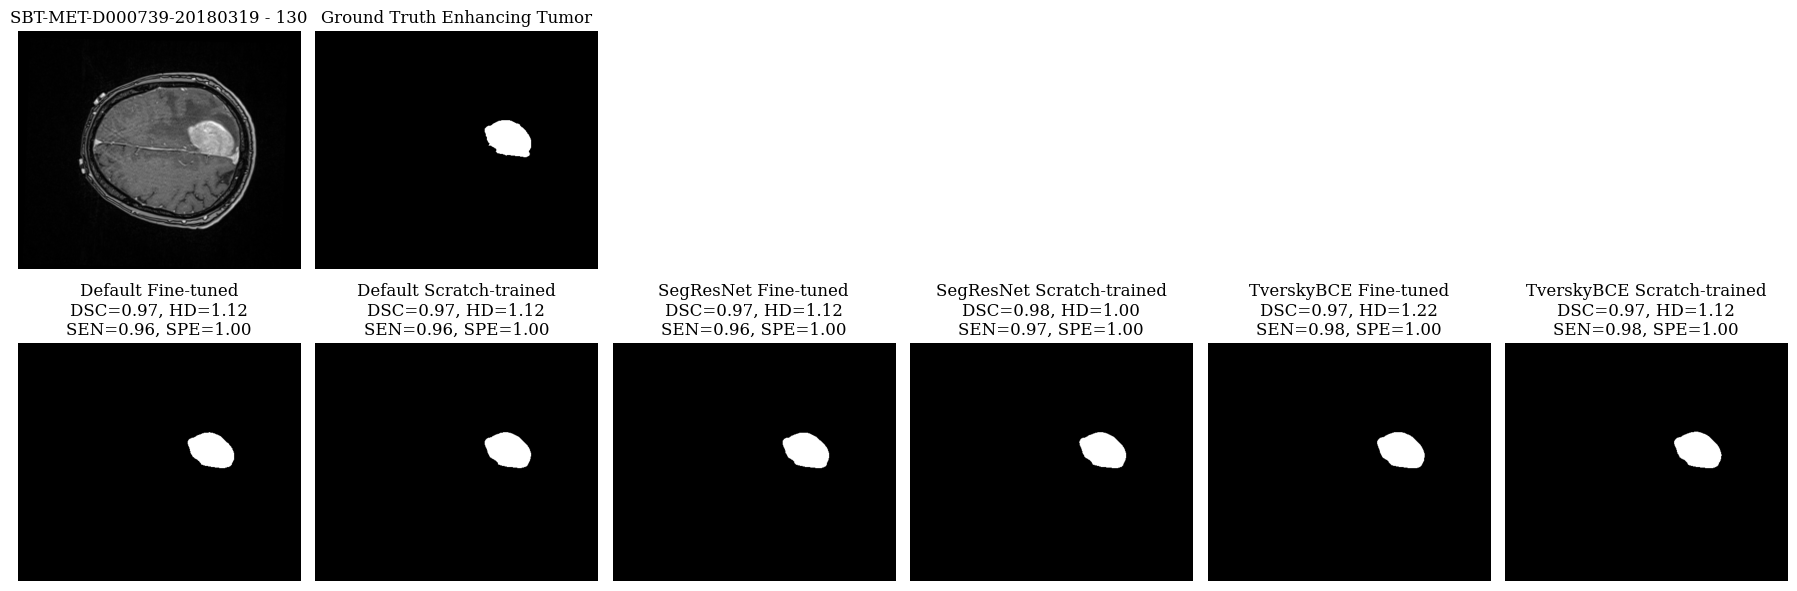

In [38]:
visualize2d(
    case_idx=2,
    slice_idx=130,
    region='ET'
) 

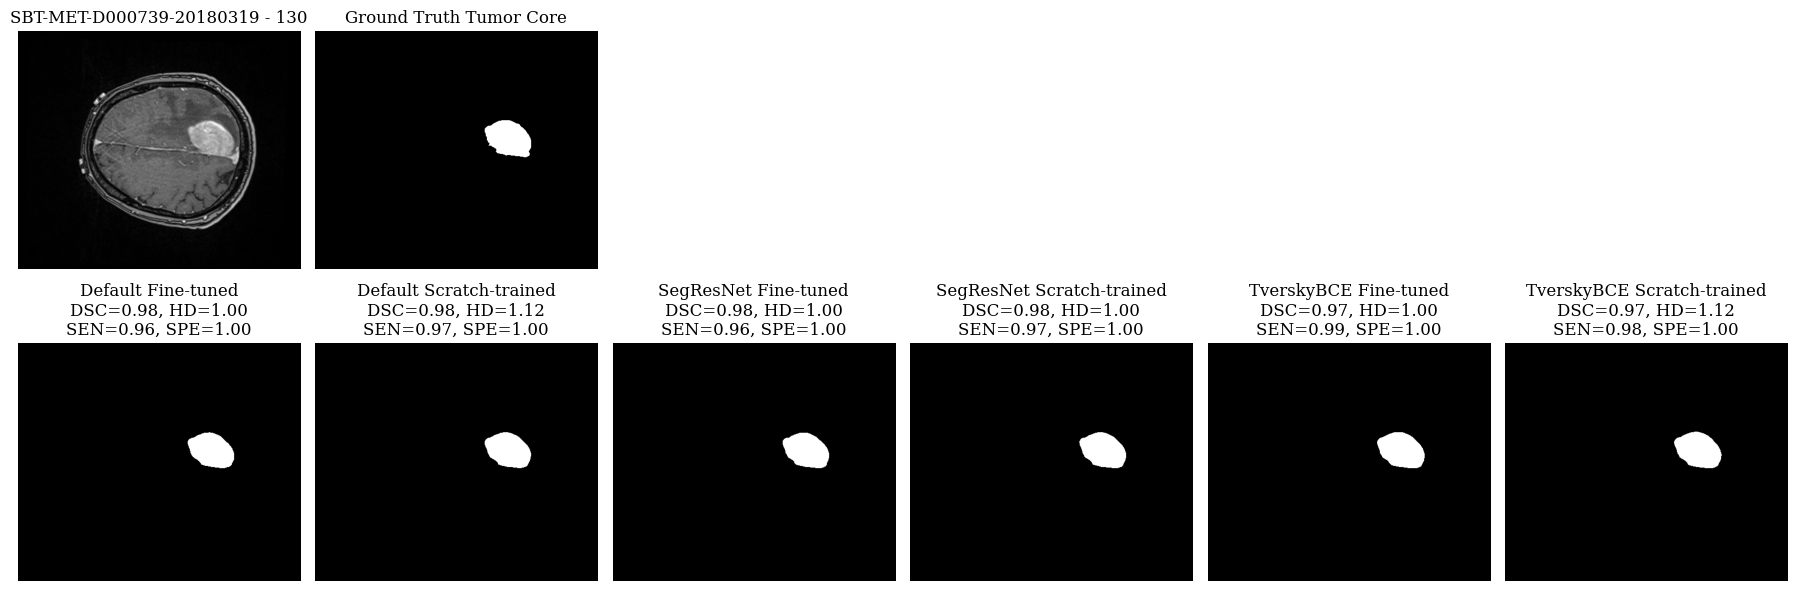

In [32]:
visualize2d(
    case_idx=2,
    slice_idx=130,
    region='TC'
) 

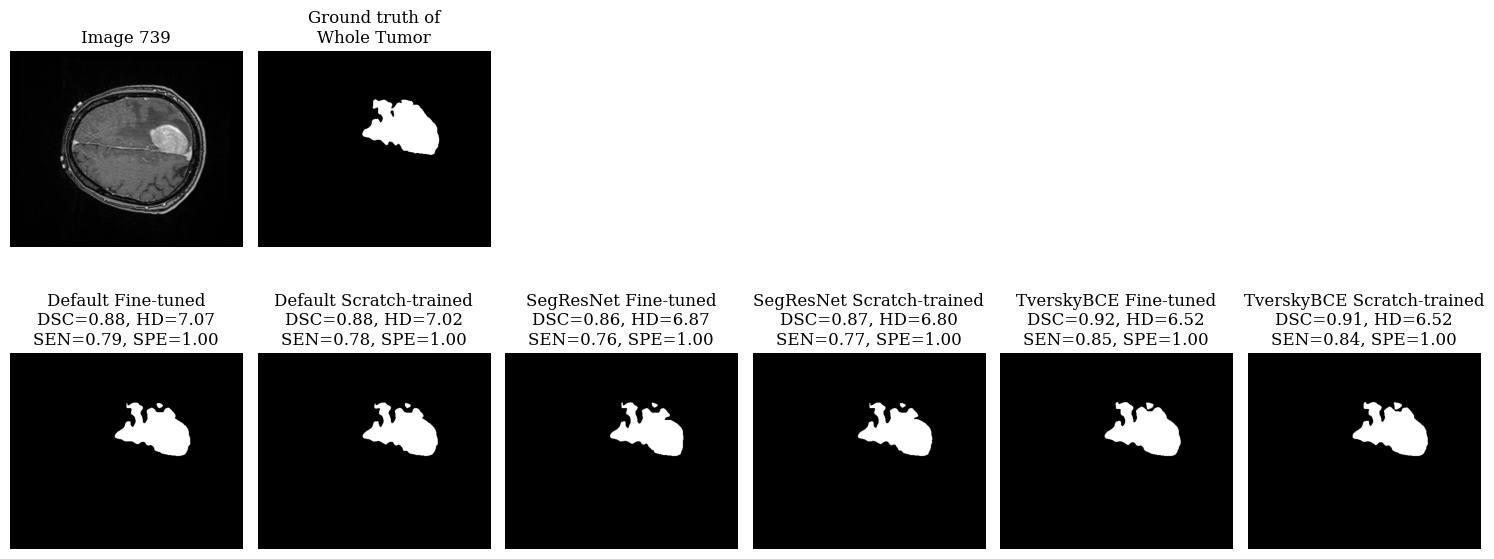

In [59]:
visualize2d(
    case_idx=2,
    slice_idx=130,
    region='WT',
    save_path='img/739.jpg'
) 

## 3. Visualize images from medical feedback

#### 3.1. Case 728

In [19]:
paths = [
    'data/img/728a.png', # gt 3D
    'data/img/728d.png', # only found by SegResNet
    'data/img/728b.png', # both models missed 
    'data/img/728c.png', # both models missed   
]

def crop_center(image, size):
    width, height = image.size
    new_width, new_height = size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    return image.crop((left, top, right, bottom))

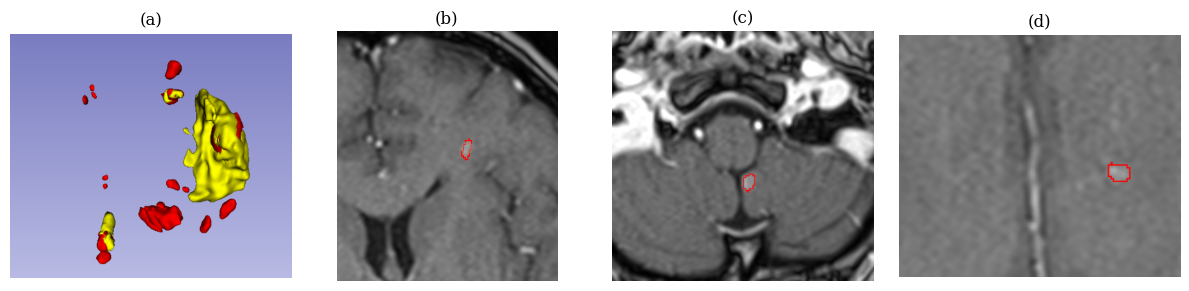

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
titles = ['(a)', '(b)', '(c)', '(d)']
for i, path in enumerate(paths):
    axs[i].imshow(plt.imread(path))
    axs[i].axis('off')
    axs[i].set_title(titles[i])

fig.tight_layout()
#fig.savefig('img/728_horizontal.jpg', format='jpeg', dpi=600)

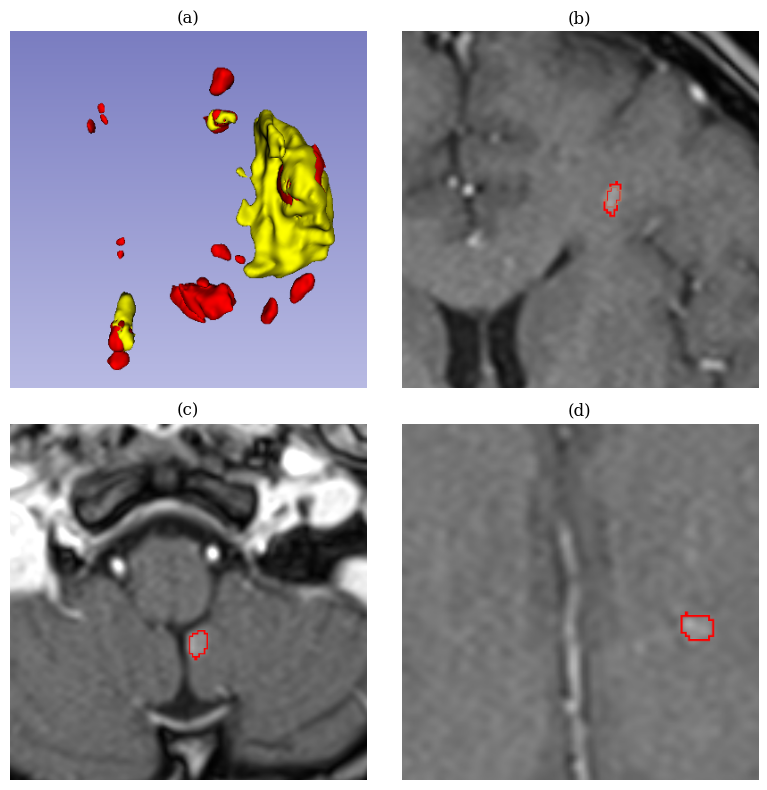

In [17]:
crop_size = (400, 400)
titles = ['(a)', '(b)', '(c)', '(d)']

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for i, path in enumerate(paths):
    image = Image.open(path)
    cropped_image = crop_center(image, crop_size)
    axs[i].imshow(cropped_image)
    axs[i].axis('off')
    axs[i].set_title(titles[i])

fig.tight_layout()
fig.savefig('img/728.jpg', format='jpeg', dpi=720)
plt.show()


#### 3.2. Case 733

In [21]:
paths = [
    'data/img/733a.png', # gt 3D
    'data/img/733b.png', # SegResNet not found necrotic
    'data/img/733c.png', # TverskyBCE found necrotic 
]

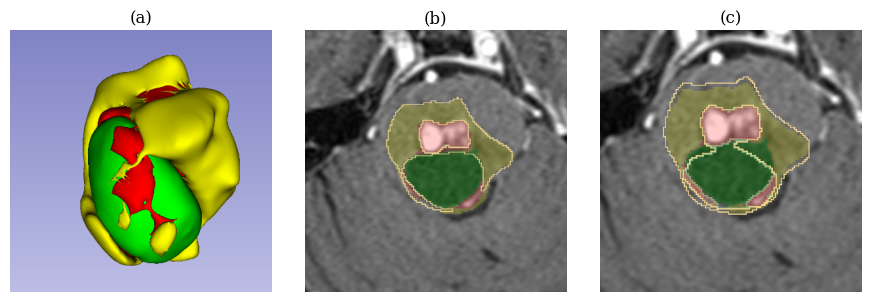

In [22]:
crop_size = (400, 400)
titles = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs = axs.flatten()

for i, path in enumerate(paths):
    image = Image.open(path)
    cropped_image = crop_center(image, crop_size)
    axs[i].imshow(cropped_image)
    axs[i].axis('off')
    axs[i].set_title(titles[i])

fig.tight_layout()
fig.savefig('img/733_feedback.jpg', format='jpeg', dpi=720)
plt.show()
